In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [27]:
import string
random = np.random.RandomState(11116)
n_points = 30
data = random.randn(n_points, n_points)

def random_word(length):
    letters = list(string.ascii_lowercase)
    letters_and_spaces = letters + [' ']
    
    if length < 3:
        label = ''.join(random.choice(letters, size=length))
    else:
        label = random.choice(letters)
        # allow spaces but not in first or last letter
        label += ''.join(random.choice(letters_and_spaces, size=length - 2))
        label += random.choice(letters)
        
    return label    

min_length = 5
max_length = 20 

labels = list(map(random_word, random.randint(min_length, max_length+1, size=n_points)))

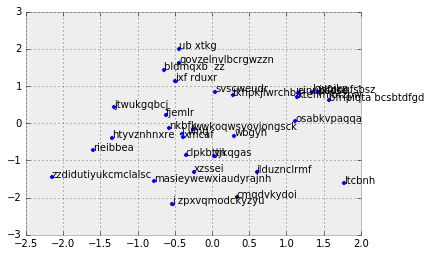

In [31]:
plt.scatter(data[0], data[1])
texts = []
for x, y, label in zip(data[0], data[1], labels):
    texts.append(plt.text(x, y, label))

In [166]:
scatter = ax.scatter(data[0], data[1])

In [181]:
scatter.get_window_extent(renderer)

Bbox([[138.247497231991, 90.96789508769096], [447.3583060395951, 310.7221471977948]])

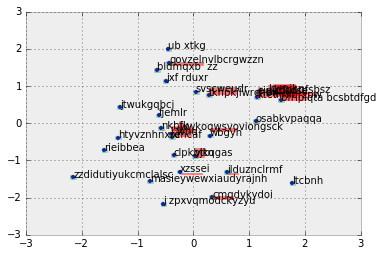

In [309]:
import itertools
from matplotlib.collections import PatchCollection

plt.figure()

ax = plt.gca()

ax.scatter(data[0], data[1])
renderer = ax.get_figure().canvas.get_renderer()
texts = []
anchors = []
for x, y, label in zip(data[0], data[1], labels):
    anchors.append(np.array([x, y]))
    texts.append(plt.text(x, y, label))
    
text = texts[0]

bboxes = [t.get_window_extent(renderer).transformed(ax.transData.inverted()) for t in texts]

intersections = []

for bbox_a, bbox_b in itertools.combinations(bboxes, 2):
    intersection = Bbox.intersection(bbox_a, bbox_b)
    
    if intersection:
        
        intersections.append(bbox_patch(intersection, fill=True))

collection = PatchCollection(intersections, color='red', alpha=.5)
ax.add_collection(collection)

anchor_bboxes = [point_bounding_box(point, 0.05) for point in anchors]
anchor_bboxes_qtree = build_qtree(anchor_bboxes, use_indices=False)
anchor_collection = PatchCollection([bbox_patch(b, fill=True) for b in anchor_bboxes], color='green', alpha=.3)
ax.add_collection(anchor_collection)

plt.plot()
plt.draw()
plt.show()

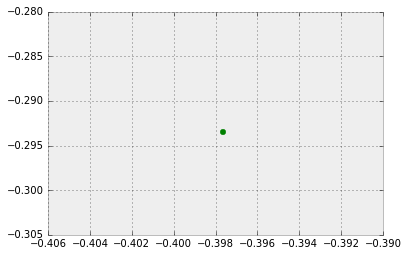

In [199]:
plt.scatter(*anchors[1], color='g', s=30)

In [129]:
bbox == Bbox(bbox.get_points())

False

In [135]:
def area(bbox):
    return bbox.width * bbox.height

In [147]:
def angle(bbox, anchor):
    bbox_mid = midpoint(bbox)
    
    angle = np.asarray(anchor)
    
    vec = bbox_mid - anchor
    
    return np.arctan2(vec[1], vec[0])

In [154]:
def position_score(bbox, anchor):
    
    a = angle(bbox, anchor)
    
    if 0 <= a <= np.pi / 2:
        return 0
    elif np.pi / 2 < a <= np.pi:
        return 1
    elif -np.pi <= a < -np.pi/2:
        return 2
    else:
        return 3

45.0
135.0
-135.0
-45.0


[]

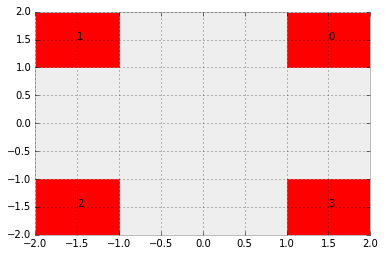

In [157]:
ur = Bbox([[1, 1], [2, 2]])
ul = Bbox([[-2, 1], [-1, 2]])
ll = Bbox([[-2, -2], [-1, -1]])
lr = Bbox([[1, -2], [2, -1]])

ax = plt.gca()


for box in [ur, ul, ll, lr]:
    
    a = angle(box, [0, 0])
    
    print(np.degrees(a))
    score = position_score(box, [0, 0])
    
    ax.text(*midpoint(box), score)
    ax.add_patch(bbox_patch(box, fill=True, color='red'))

ax.plot()

In [149]:
angle(bbox, [1000, 1000])

-2.2355122402440859

In [160]:
def line_intersection(x1, x2, x3, x4, y1, y2, y3, y4):
    # Just borrowed this from https://github.com/tinker10/D3-Labeler/blob/master/labeler.js

    denom = (y4 - y3) * (x2 - x1) - (x4 - x3) * (y2 - y1)
    numera = (x4 - x3) * (y1 - y3) - (y4 - y3) * (x1 - x3)
    numerb = (x2 - x1) * (y1 - y3) - (y2 - y1) * (x1 - x3)

    
    mua = numera / denom;
    mub = numerb / denom;
    
    ans = ~((mua < 0) or (mua > 1) or (mub < 0) or (mub > 1))
    
    return ans

In [298]:
import pyqtree

In [308]:
def build_qtree(bboxes, use_indices=True):
    min_x = np.inf
    max_x = -np.inf
    min_y = np.inf
    max_y = -np.inf

    for x0, y0, x1, y1 in map(lambda x: x.get_points().ravel(), bboxes):

        min_x = min(min_x, x0)
        max_x = max(max_x, x1)

        min_y = min(min_y, y0)
        max_y = max(max_y, y1)
        
    index = pyqtree.Index((min_x, min_y, max_x, max_y))

    for i, bbox in enumerate(bboxes):
        if use_indices:
            item = i
        else:
            item = bbox
        
        index.insert(item, bbox.get_points().ravel())
        
    return index

In [319]:
Bbox.intersection??

In [336]:
import itertools

def energy(label_bboxes, 
           anchors,
           non_label_bboxes,
           w_line_length=0.2,
           w_orientation_penalty=3.0,
           w_intersecting_lines=1.0,
           w_bbox_overlap=30.0,
           w_non_label_bbox_overlap=30.0):
    
    ans = 0    
    

    overlap_area = 0
 
    n_intersecting_lines = 0
    
    for (bbox, anchor), (other_bbox, other_anchor) in itertools.combinations(zip(label_bboxes, anchors), 2):
        
        # penalty for bbox overlap
        intersection = Bbox.intersection(bbox, other_bbox)
        if intersection:
            overlap_area += area(intersection)
            
        anchor_x, anchor_y = anchor 
        midpoint_x, midpoint_y = midpoint(bbox)
        
        other_anchor_x, other_anchor_y = other_anchor
        other_midpoint_x, other_midpoint_y = midpoint(other_bbox)
        
        # penalty for intersecting lines
        if line_intersection(anchor_x, midpoint_x, other_anchor_x, other_midpoint_x,
                             anchor_y, midpoint_y, other_anchor_y, other_midpoint_y):
            n_intersecting_lines += 1
        
    
    ans += overlap_area * w_bbox_overlap
    ans += n_intersecting_lines * w_intersecting_lines
    
    for bbox, anchor in zip(label_bboxes, anchors):
        # compute penalty for distance away from anchor
        ans += distance_bbox_to_point(bbox, anchor) * w_line_length

        # compute orientation penalty
        ans += position_score(bbox, anchor) * w_orientation_penalty

        # compute penalty for overlap with other bboxes:
        non_label_overlap_area = 0
       
        for non_label_bbox in non_label_bboxes:
            # penalty for the bbox overlap
            intersection = Bbox.intersection(bbox, non_label_bbox)
            if intersection:
                non_label_overlap_area += area(intersection)
    
        ans += non_label_overlap_area * w_non_label_bbox_overlap
        
    return ans

In [221]:
np.array([1,2,3,4,5,6]).reshape(-1, 2)[0]

array([1, 2])

In [359]:
def adjust_bboxes(deltas, bboxes):
    deltas = deltas.reshape(-1, 2)
    
    new_bboxes = []
    for delta, bbox in zip(deltas, bboxes):
        
        a, b = bbox.get_points()
        new_bboxes.append(Bbox([a+delta, b+delta]))
    
    return new_bboxes

def objective(bboxes, anchors, anchor_bboxes_qtree):
    
    def f(deltas):
        new_bboxes = adjust_bboxes(deltas, bboxes)
        
        total_energy = energy(new_bboxes, anchors, anchor_bboxes_qtree)
        
        return total_energy

    return f
    

In [322]:
from simanneal import Annealer

In [376]:

class LabelAnnealer(Annealer):
    
    Tmax = 2.0
    Tmin = 0.0001
    steps = 5000
    updates = 50
    
    max_step = 0.5
    max_angle = np.pi
    
    def __init__(self, state, bboxes, anchors, anchor_bboxes):
        self.bboxes = bboxes
        self.anchors = anchors
        self.anchor_bboxes = anchor_bboxes
        
        super(LabelAnnealer, self).__init__(state)
    
    def energy(self):
        new_bboxes = adjust_bboxes(self.state, self.bboxes)
        total_energy = energy(new_bboxes, self.anchors, self.anchor_bboxes)
        return total_energy
        
    def move(self):
        x = self.state
        x = x.reshape(-1, 2)
        
        i = np.random.choice(range(len(x)))
        
        step_type = np.random.choice(['translate', 'rotate'])
        if step_type == 'translate':        
            s = self.max_step
            x[i, 0] += np.random.uniform(-s, s)
            x[i, 1] += np.random.uniform(-s, s)
        elif step_type == 'rotate':
            a = np.random.uniform(-self.max_angle, self.max_angle)
            sin_ = np.sin(a)
            cos_ = np.cos(a)
            
            anchor = self.anchors[i]
            mp = midpoint(self.bboxes[i])
            
            # adjust midpoint to delta
            mp = mp + x[i]
            
            # translate to zero:
            mp -= anchor
            
            new_mp = np.array([cos_ * mp[0] - sin_ * mp[1], sin_ * mp[0] + cos_ * mp[1]])
            
            # translate back to real coordinates
            new_mp += anchor
            mp += anchor
            
            new_delta = new_mp - mp
            x[i] = new_delta            
            
        else:
            raise Exception('Unexpected step type: [step_type]')
            

        x = x.reshape(-1)
        
        self.state = x
        

In [377]:
x0 = np.asarray([0, 0] * len(bboxes), dtype=float)
problem = LabelAnnealer(x0, bboxes, anchors, anchor_bboxes)
print(problem.energy())

45.5479606105


In [378]:
problem.state

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [379]:
state, e = problem.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
        2.00         45.55                         0:00:00            
        1.64         29.59    34.00%    24.00%     0:00:04     0:03:01
        1.35         40.02    32.00%    14.00%     0:00:07     0:02:42
        1.10         29.23    35.00%    17.00%     0:00:10     0:02:34
        0.91         20.98    33.00%    18.00%     0:00:13     0:02:29
        0.74         16.41    35.00%    18.00%     0:00:16     0:02:25
        0.61         13.18    30.00%    12.00%     0:00:19     0:02:21
        0.50         14.28    23.00%    11.00%     0:00:22     0:02:17
        0.41         15.00    20.00%    10.00%     0:00:25     0:02:14
        0.34         12.52    30.00%    16.00%     0:00:29     0:02:10
        0.28         10.92    21.00%     9.00%     0:00:32     0:02:07
        0.23          8.14    20.00%    13.00%     0:00:35     0:02:03
        0.19          8.03    20.00%     9.00%     0:00:38     0:01:59
      

In [380]:
e

3.774202630458197

In [315]:
from numba import jit

In [311]:
func = objective(bboxes, anchors, anchor_bboxes_qtree)

In [317]:
x0 = np.asarray([0, 0] * len(bboxes), dtype=float)
%timeit func(x0)

LoweringError: Failed at object (object mode frontend)
Failed at object (object mode backend)
ans.2
File "<ipython-input-316-165b4f06c8cb>", line 20
[1] During: lowering "$228 = call $227(anchors, ans.2, label_bboxes, non_label_bboxes_qtree, overlap_area, qtree, seen_overlaps, w_bbox_overlap, w_intersecting_lines, w_line_length, w_non_label_bbox_overlap, w_orientation_penalty)" at <ipython-input-316-165b4f06c8cb> (20)

In [272]:
np.random.normal?

In [278]:
class MyTakeStep(object):
    def __init__(self, stepsize=0.1):
           self.stepsize = stepsize
    
    def __call__(self, x):
        
        x = x.reshape(-1, 2)
        
        i = np.random.choice(range(len(x)))
        
        s = self.stepsize
        x[i, 0] += np.random.uniform(-s, s)
        x[i, 1] += np.random.uniform(-s, s)
        
        x = x.reshape(-1)
        return x

In [313]:
x0 = np.asarray([0, 0] * len(bboxes), dtype=float)
result = scipy.optimize.basinhopping(func, T=10, x0=x0, disp=True, 
                                     niter=10, 
                                     take_step=takestep,
                                     minimizer_kwargs=dict(options=dict(maxiter=5, disp=True)))

         Current function value: 236.790447
         Iterations: 3
         Function evaluations: 4906
         Gradient evaluations: 79
basinhopping step 0: f 236.79
         Current function value: 237.757593
         Iterations: 0
         Function evaluations: 4411
         Gradient evaluations: 71
basinhopping step 1: f 237.758 trial_f 237.758 accepted 1  lowest_f 236.79
         Current function value: 237.639783
         Iterations: 0
         Function evaluations: 4349
         Gradient evaluations: 70
basinhopping step 2: f 237.64 trial_f 237.64 accepted 1  lowest_f 236.79
         Current function value: 239.538007
         Iterations: 0
         Function evaluations: 4040
         Gradient evaluations: 65
basinhopping step 3: f 239.538 trial_f 239.538 accepted 1  lowest_f 236.79
         Current function value: 231.750357
         Iterations: 3
         Function evaluations: 7575
         Gradient evaluations: 122
basinhopping step 4: f 231.75 trial_f 231.75 accepted 1  lowe

KeyboardInterrupt: 

In [292]:
result.x

array([ 0.11799559,  0.09130533,  0.00085622, -0.02347669, -0.06104295,
        0.04757073,  0.08708031, -0.10928961, -0.0018259 ,  0.07180573,
       -0.06244818,  0.00117565, -0.08868384,  0.07571906, -0.02993588,
       -0.07721948,  0.0825492 , -0.11447249, -0.05506749,  0.09061685,
        0.13812766, -0.27401199, -0.12724089,  0.0587702 , -0.19458462,
       -0.15451612, -0.06253683,  0.00147196, -0.05546757, -0.05084961,
       -0.12373158,  0.05450996, -0.07717557, -0.07589471, -0.05841989,
       -0.09565857, -0.06795903,  0.0605257 , -0.17352248,  0.02219513,
       -0.06049799, -0.00466751, -0.06232661,  0.07165765, -0.0623252 ,
        0.00051444, -0.03864531, -0.07694681, -0.0438956 , -0.0120081 ,
        0.00994188,  0.42102154, -0.00362365, -0.16588486, -0.02767908,
       -0.17947915, -0.03811817,  0.00512468, -0.05339336,  0.07540595])

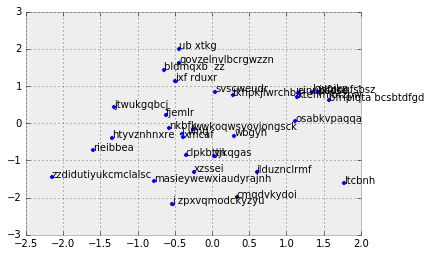

In [381]:
import itertools
from matplotlib.collections import PatchCollection

plt.figure()

ax = plt.gca()

ax.scatter(data[0], data[1])
renderer = ax.get_figure().canvas.get_renderer()
texts = []
anchors = []
for x, y, label in zip(data[0], data[1], labels):
    anchors.append(np.array([x, y]))
    texts.append(plt.text(x, y, label))
    
for text, delta in zip(texts, problem.state.reshape(-1, 2)):
    pos = text.get_position()

    
plt.plot()
plt.draw()
plt.show()

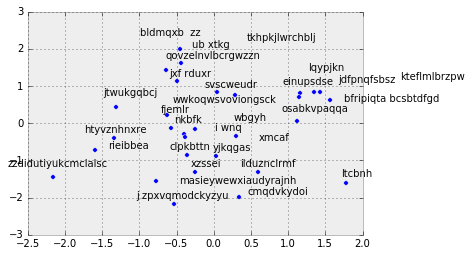

In [382]:
import itertools
from matplotlib.collections import PatchCollection

plt.figure()

ax = plt.gca()

ax.scatter(data[0], data[1])
renderer = ax.get_figure().canvas.get_renderer()
texts = []
anchors = []
for x, y, label in zip(data[0], data[1], labels):
    anchors.append(np.array([x, y]))
    texts.append(plt.text(x, y, label))
    
for text, delta in zip(texts, problem.state.reshape(-1, 2)):
    pos = text.get_position()
    text.set_position(pos + delta)
    
plt.plot()
plt.draw()
plt.show()

In [94]:
from matplotlib.transforms import Bbox

In [87]:
def midpoint(bbox):
    x0, y0, x1, y1 = bbox.get_points().ravel()
    return np.array([x0 + (x1 - x0) / 2, y0 + (y1 - y0) / 2])

In [63]:
bbox = bboxes[0]

In [97]:
Bbox.intersection(bboxes[0], bboxes[1])

In [107]:
import matplotlib.patches as patches
def bbox_patch(bbox, **kwargs):
    x0, y0, x1, y1 = bbox.get_points().ravel()
    width, height = bbox.width, bbox.height
    
    patch = patches.Rectangle((x0, y0), width, height, **kwargs)
    return patch
    

In [91]:
def distance_bbox_to_point(bbox, point):
    bbox_midpoint = midpoint(bbox)
    point = np.asarray(point)
    return np.sqrt(np.sum(np.square(bbox_midpoint - point)))

In [92]:
distance_bbox_to_point(bbox, [0, 0])

480.03046111150894

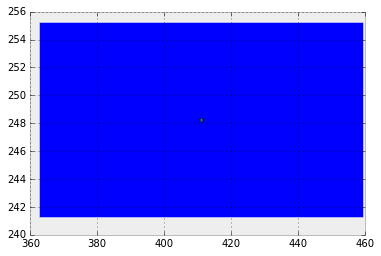

In [88]:
ax = plt.gca()
ax.add_patch(bbox_patch(bbox, fill=True))


plt.plot(*midpoint(bbox), linestyle='', marker='*')

In [58]:
label = Label(text, renderer)

In [60]:
label.bbox()

AttributeError: 'NoneType' object has no attribute 'dpi'

In [39]:
max_move = 5.0
max_angle = 0.5

w_len = 0.2 # leader line length
w_inter = 1.0 # leader line intersection
w_lab2 = 30.0 # label-label overlap
w_lab_anc = 30.0 # label-anchor overlap
w_orient = 3.0 # orientation bias

In [40]:
import scipy.optimize

In [41]:
scipy.optimize.basinhopping?

In [ ]:
def energy(index):
    m = len(texts)
    
    ener = 0
    
    